**Juan José Solórzano Carrillo**



```
`# This is formatted as code`
```

# **Aprendizaje Profundo con TensorFlow **



In [ ]:
#Configuración
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

#Modelo
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
#Tamaño de la imagen
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))])

In [ ]:
#Conjunto de datos Cats
Cats = '/content/drive/MyDrive/Colab Notebooks/Cats1'
batch_size = 50
img_height = 224
img_width = 224
#Se cargan los datos al modelo pre-entrenado
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(Cats),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 348 files belonging to 6 classes.
Using 279 files for training.


In [ ]:
#Se obtienen las diferentes clases de razas de gatos (sólo se toman 5 tipos de razas)
class_names = np.array(train_ds.class_names)
print(class_names)
#Normalización de los datos
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))


['Abyssinian' 'Bengal' 'Manx' 'Persian' 'Siamese' 'Tiger']


In [ ]:
#Normalización
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
#labels_path ='/content/drive/MyDrive/Colab Notebooks/Cats1/DataCats.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [ ]:
#
for Cats1, labels_batch in train_ds:
  print(Cats1.shape)
  print(labels_batch.shape)
  break

#Se entrena el modelo 
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

(50, 224, 224, 3)
(50,)


array(['sleeping bag', 'tabby', 'Egyptian cat', 'Egyptian cat',
       'malinois', 'Persian cat', 'Siamese cat', 'Egyptian cat',
       'mongoose', 'Shih-Tzu', 'Egyptian cat', 'Persian cat',
       'Persian cat', 'Egyptian cat', 'tiger cat', 'tabby', 'chest',
       'Egyptian cat', 'Persian cat', 'bath towel', 'Persian cat',
       'tabby', 'grocery store', 'tabby', 'Egyptian cat', 'Egyptian cat',
       'Persian cat', 'Siamese cat', 'Siamese cat', 'Egyptian cat',
       'Egyptian cat', 'Siamese cat', 'Persian cat', 'tiger cat', 'tabby',
       'Egyptian cat', 'Angora', 'Angora', 'tabby', 'Egyptian cat',
       'Egyptian cat', 'Egyptian cat', 'Persian cat', 'Egyptian cat',
       'Egyptian cat', 'Egyptian cat', 'tabby', 'tiger cat', 'tiger cat',
       'Persian cat', 'Egyptian cat', 'Persian cat', 'Siamese cat',
       'tiger cat', 'Egyptian cat', 'lynx', 'Egyptian cat',
       'Egyptian cat', 'tabby', 'Egyptian cat', 'Egyptian cat',
       'Persian cat', 'Egyptian cat', 'Egyptian cat'

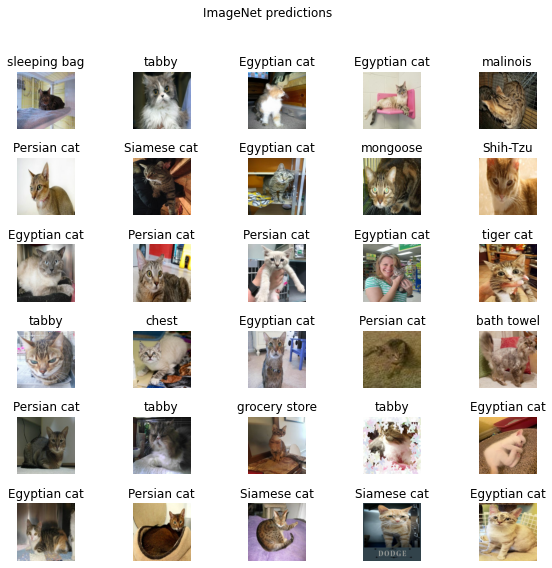

In [ ]:
#Se grafican los resultados
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(Cats1[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')


#Los resultados no son del todo buenos, pero tomando en cuanta que el modelo no se entreno para estos datos, sí acierta en algunos casos.
_ = plt.suptitle("ImageNet predictions")

In [ ]:
#Volvemos a cargar el modelo
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
#Se entrena solo la capa del clasificador
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
#Devuelve un vector de 1280 de longitud para cada imagen
feature_batch = feature_extractor_layer(Cats1)
print(feature_batch.shape)

(50, 1280)


In [ ]:
#Etiquetas encontradas
class_names

array(['Abyssinian', 'Bengal', 'Manx', 'Persian', 'Siamese', 'Tiger'],
      dtype='<U10')

In [ ]:
#Se agregan las etiquetas de clasificación al modelo
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#Volvemos a pasar el conjunto de datos Cats1
predictions = model(Cats1)
predictions.shape

TensorShape([50, 6])

# **Resultados con: epochs=2**

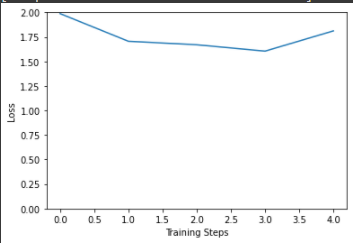

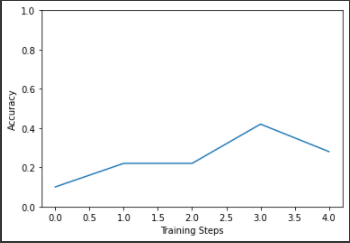

**Mala predicción**

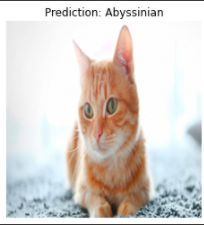

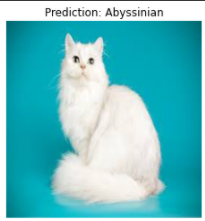

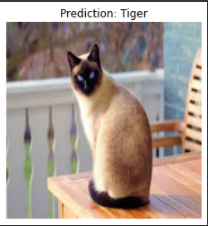

In [ ]:
#Se entrena el modelo 
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=12,callbacks=[batch_stats_callback])

Epoch 1/12
6/6 [==============================] - 10s 1s/step - loss: 1.7248 - acc: 0.2759
Epoch 2/12
6/6 [==============================] - 7s 1s/step - loss: 1.3097 - acc: 0.5172
Epoch 3/12
6/6 [==============================] - 7s 1s/step - loss: 0.9860 - acc: 0.7586
Epoch 4/12
6/6 [==============================] - 7s 1s/step - loss: 0.8560 - acc: 0.7931
Epoch 5/12
6/6 [==============================] - 6s 1s/step - loss: 0.7571 - acc: 0.7586
Epoch 6/12
6/6 [==============================] - 7s 1s/step - loss: 0.6522 - acc: 0.7931
Epoch 7/12
6/6 [==============================] - 7s 1s/step - loss: 0.5759 - acc: 0.8966
Epoch 8/12
6/6 [==============================] - 7s 1s/step - loss: 0.5240 - acc: 0.8966
Epoch 9/12
6/6 [==============================] - 7s 1s/step - loss: 0.4761 - acc: 0.9310
Epoch 10/12
6/6 [==============================] - 7s 1s/step - loss: 0.4316 - acc: 0.9310
Epoch 11/12
6/6 [==============================] - 6s 1s/step - loss: 0.3958 - acc: 0.9655
Epoch 1

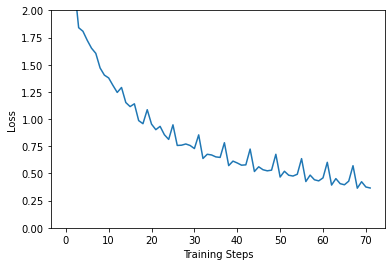

In [ ]:
#Se observa como el modelo mejora al aumentar los épocas
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)


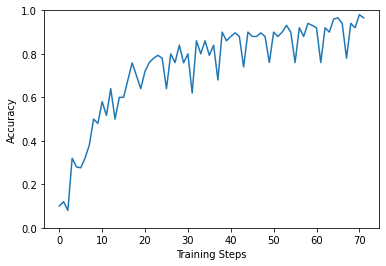

In [ ]:
#Amunta la precisión 
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

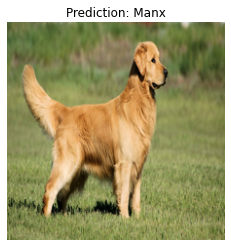

In [ ]:
Imagen = '/content/drive/MyDrive/Colab Notebooks/Perro1.jpg'
Gato = Image.open(Imagen).resize(IMAGE_SHAPE)

#Tamaño
Gato = np.array(Gato)/255.0

predicted_batch = model.predict(Gato[np.newaxis, ...])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.imshow(Gato)
plt.axis('off')
predicted_class_name = predicted_label_batch[0]
_ = plt.title("Prediction: " + predicted_class_name.title())

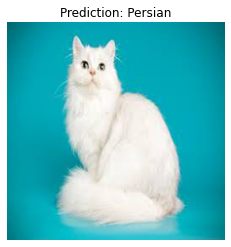

In [ ]:
Imagen = '/content/drive/MyDrive/Colab Notebooks/GatosTest/Gato3.jpg'
Gato = Image.open(Imagen).resize(IMAGE_SHAPE)

#Tamaño
Gato = np.array(Gato)/255.0

predicted_batch = model.predict(Gato[np.newaxis, ...])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.imshow(Gato)
plt.axis('off')
predicted_class_name = predicted_label_batch[0]
_ = plt.title("Prediction: " + predicted_class_name.title())

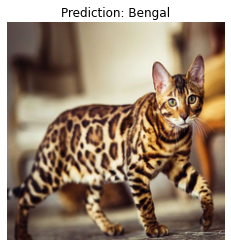

In [ ]:
Imagen = '/content/drive/MyDrive/Colab Notebooks/GatosTest/Gato4.jpg'
Gato = Image.open(Imagen).resize(IMAGE_SHAPE)

#Tamaño
Gato = np.array(Gato)/255.0

predicted_batch = model.predict(Gato[np.newaxis, ...])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.imshow(Gato)
plt.axis('off')
predicted_class_name = predicted_label_batch[0]
_ = plt.title("Prediction: " + predicted_class_name.title())

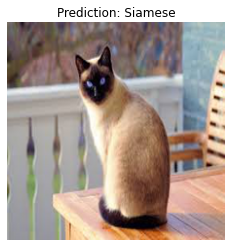

In [ ]:
Imagen = '/content/drive/MyDrive/Colab Notebooks/GatosTest/Gato5.jpg'
Gato = Image.open(Imagen).resize(IMAGE_SHAPE)

#Tamaño
Gato = np.array(Gato)/255.0

predicted_batch = model.predict(Gato[np.newaxis, ...])
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.imshow(Gato)
plt.axis('off')
predicted_class_name = predicted_label_batch[0]
_ = plt.title("Prediction: " + predicted_class_name.title())